In [ ]:
from __future__ import division
from __future__ import print_function

import copy
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms
from datetime import datetime
from pathlib import Path

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.1.0+cu118
Torchvision Version:  0.16.0+cu118


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_path, num_epochs=25, is_inception=False):
    Path(save_path).mkdir(parents=True, exist_ok=True)
    since = time.time()

    acc_train_history = []
    loss_train_history = []
    acc_val_history = []
    loss_val_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(), 'loss': loss},
                           f'{save_path}/best.pt')

            if phase == 'val':
                loss_val_history.append(epoch_loss)
                acc_val_history.append(epoch_acc)

            if phase == 'train':
                loss_train_history.append(epoch_loss)
                acc_train_history.append(epoch_acc)

            if epoch % 10 == 0:
                torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(), 'loss': loss},
                           f'{save_path}/model_{epoch}.pt')
            torch.save(
                {'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
                 'loss': loss},
                f'{save_path}/last.pt')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    N = num_epochs
    plt.style.use("ggplot")
    fig = plt.figure()
    plt.plot(np.arange(0, N), acc_train_history, label="train_acc")
    plt.plot(np.arange(0, N), acc_val_history, label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    fig.savefig(f'Accuracy_{model_name}.png')

    plt.style.use("ggplot")
    fig = plt.figure()
    plt.plot(np.arange(0, N), loss_train_history, label="train_loss")
    plt.plot(np.arange(0, N), loss_val_history, label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    fig.savefig(f'Loss_{model_name}.png')

    model.load_state_dict(best_model_wts)

    return model, acc_val_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "AlexNet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "VGG11-BN":
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "SqueezeNet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model_ft.num_classes = num_classes
        input_size = 224
    elif model_name == "DenseNet":
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "Inceptionv3":
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 27.4MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

TypeError: ignored

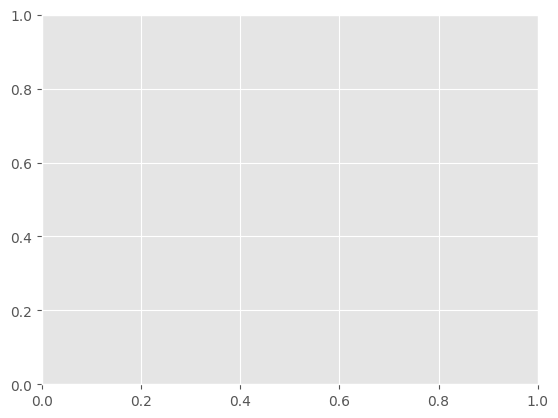

In [ ]:
data_dir = '/content/drive/MyDrive/dataset'

model_name = "DenseNet"

num_classes = 40

batch_size = 8

num_epochs = 2

mode = 'test'

feature_extract = False

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders_dict = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in
    ['train', 'val']}

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

save_path = datetime.now().strftime("%d-%m-%Y_%H%M")

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, save_path=save_path,
                             num_epochs=num_epochs, is_inception=(model_name == "Inceptionv3"))

In [ ]:
import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
model_ft.eval()
model_ft.to(device)
model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Modelo/best.pt')['model_state_dict'])

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

data_dir = '/content/drive/MyDrive/dataset/val'
test_dataset = datasets.ImageFolder(os.path.join(data_dir), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft.to(device)
model_ft.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)

print("Matriz de Confusión:")
print(conf_matrix)

Matriz de Confusión:
[[18  0  0 ...  0  0  0]
 [ 0 17  0 ...  0  0  0]
 [ 0  0 17 ...  0  0  1]
 ...
 [17  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  5  0]
 [ 2  1  0 ...  0  0 14]]


In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

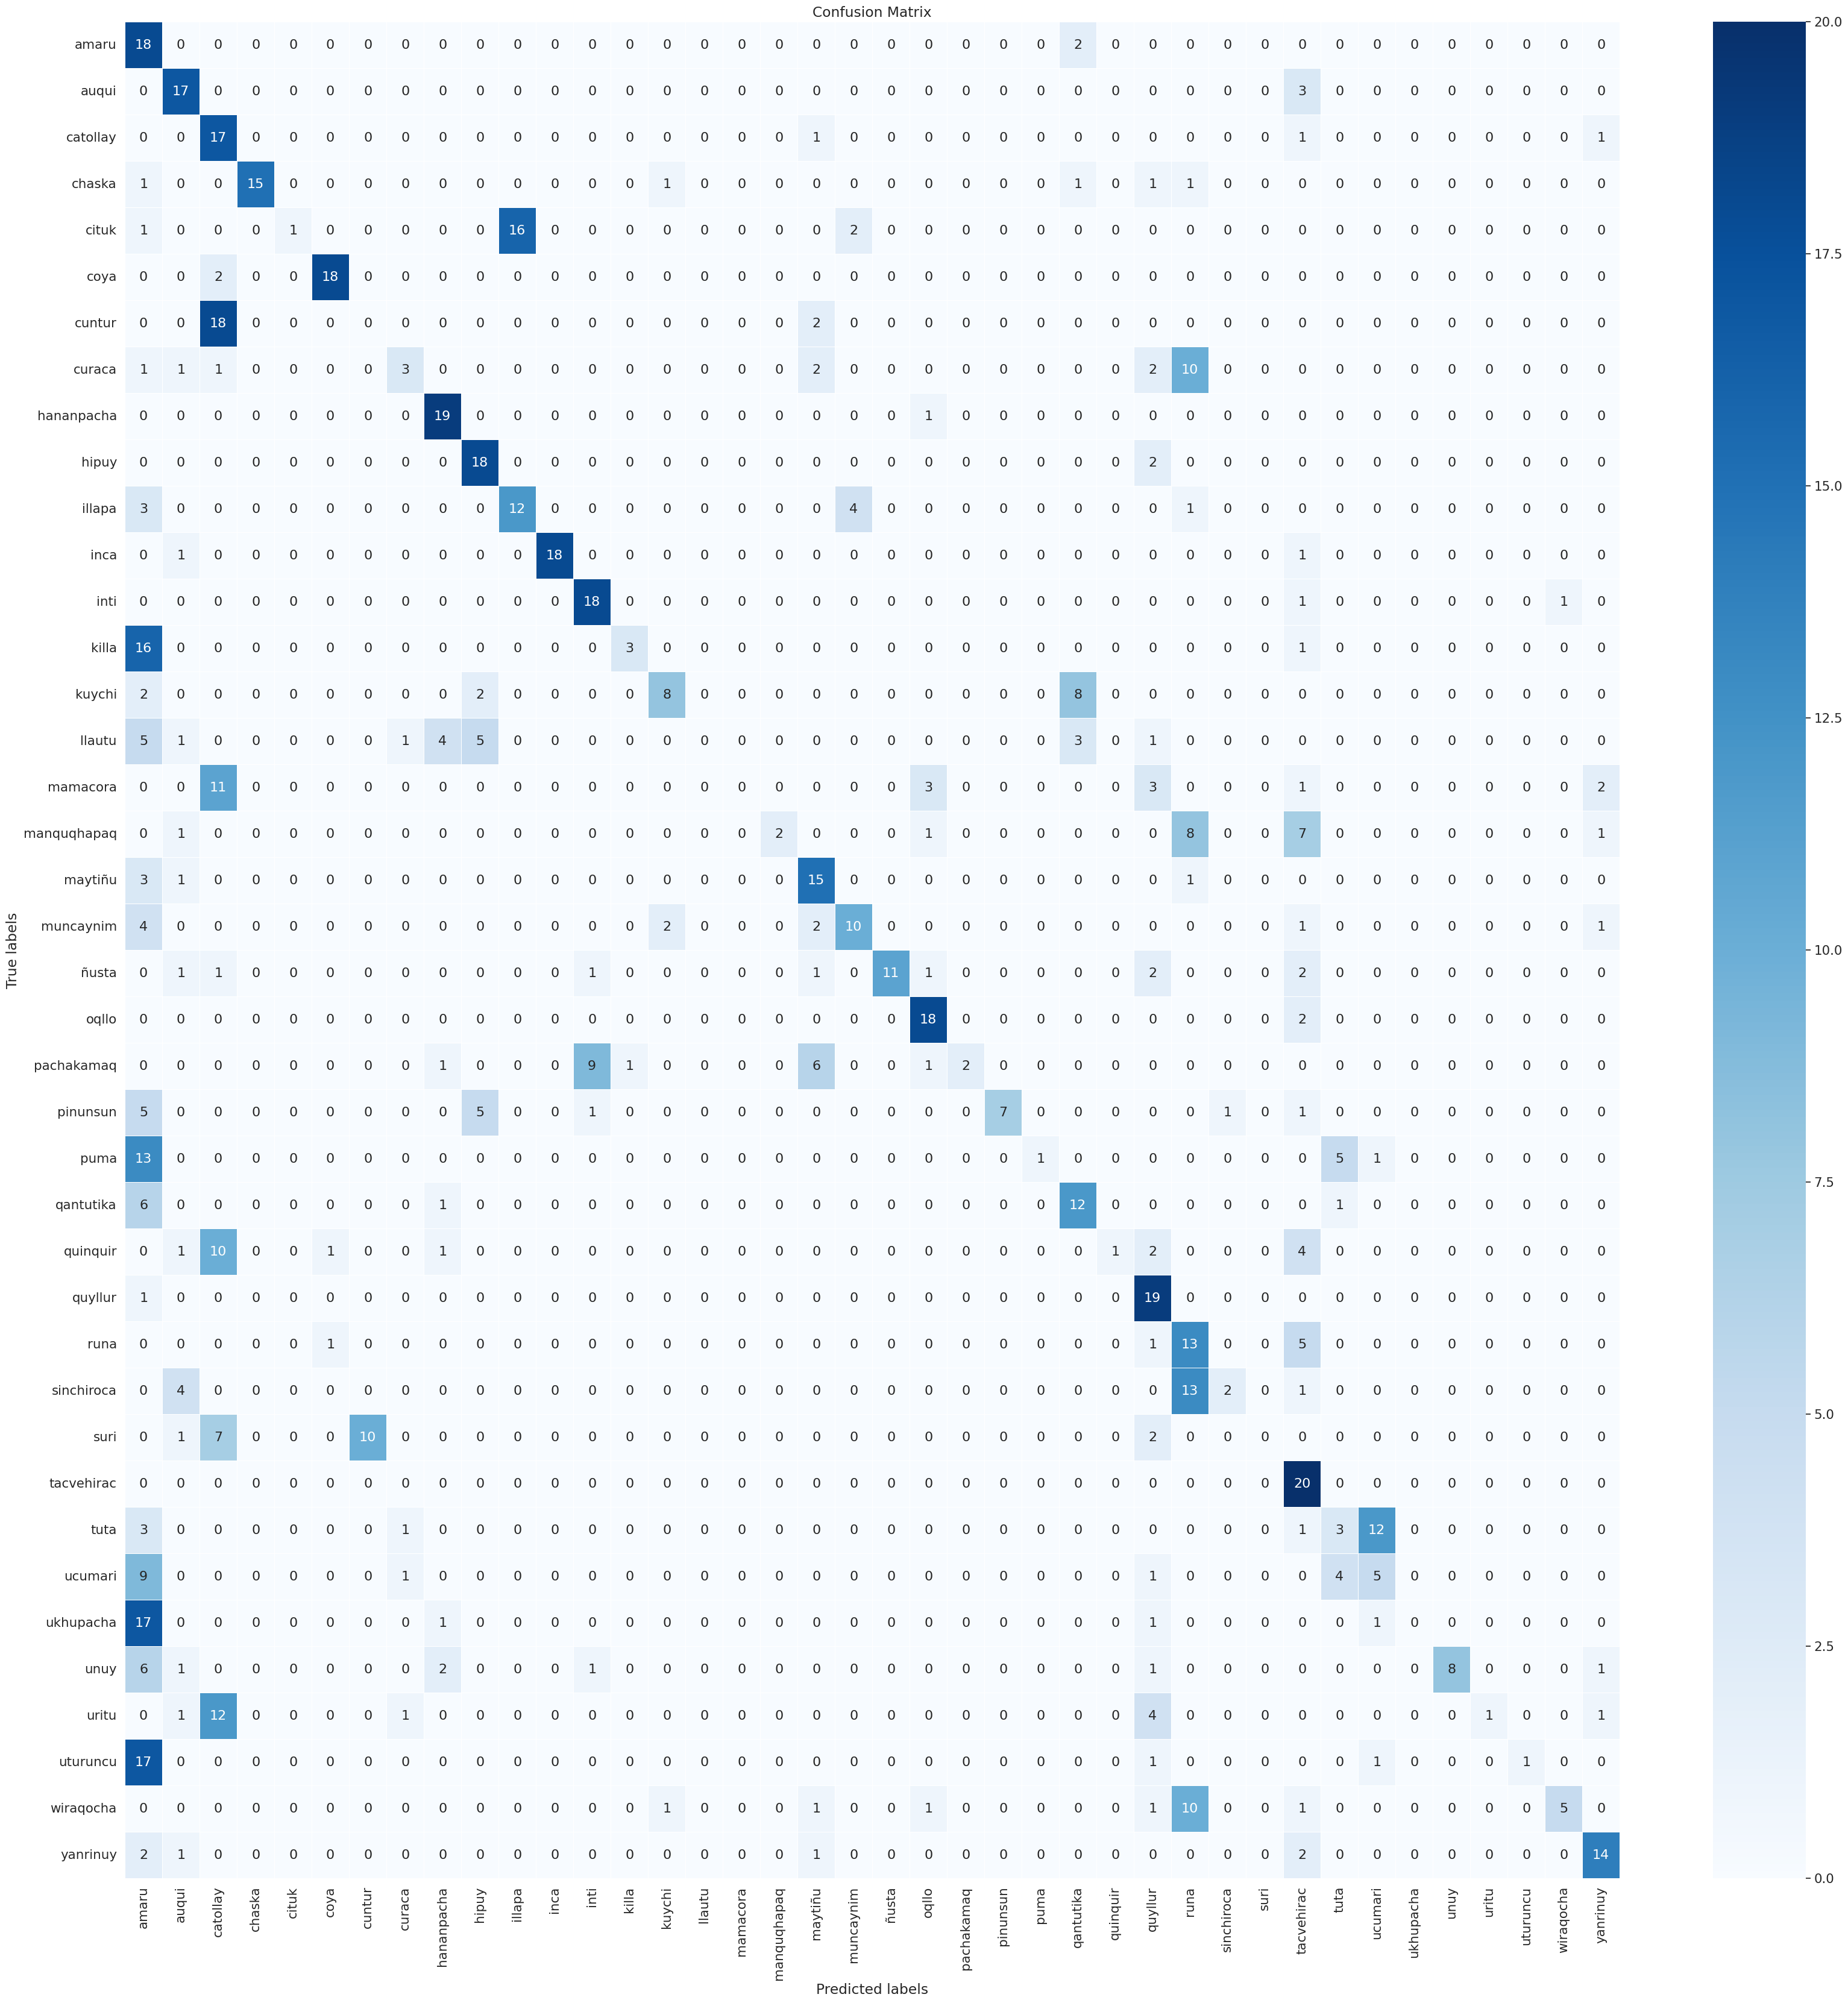

In [ ]:
df_cm = pd.DataFrame(conf_matrix, range(40), range(40))
#plt.figure(figsize=(40,40))
fig = plt.figure(figsize=(40,40))
sn.set(font_scale=1.4)

sn.heatmap(df_cm, annot=True, linewidths=0.5, linecolor="w", annot_kws={"size": 16},xticklabels=['amaru', 'auqui', 'catollay', 'chaska', 'cituk', 'coya', 'cuntur', 'curaca', 'hananpacha', 'hipuy', 'illapa', 'inca', 'inti', 'killa', 'kuychi', 'llautu', 'mamacora', 'manquqhapaq', 'maytiñu', 'muncaynim', 'ñusta', 'oqllo', 'pachakamaq', 'pinunsun', 'puma', 'qantutika', 'quinquir', 'quyllur', 'runa', 'sinchiroca', 'suri', 'tacvehirac', 'tuta', 'ucumari', 'ukhupacha', 'unuy', 'uritu', 'uturuncu', 'wiraqocha', 'yanrinuy'],yticklabels=['amaru', 'auqui', 'catollay', 'chaska', 'cituk', 'coya', 'cuntur', 'curaca', 'hananpacha', 'hipuy', 'illapa', 'inca', 'inti', 'killa', 'kuychi', 'llautu', 'mamacora', 'manquqhapaq', 'maytiñu', 'muncaynim', 'ñusta', 'oqllo', 'pachakamaq', 'pinunsun', 'puma', 'qantutika', 'quinquir', 'quyllur', 'runa', 'sinchiroca', 'suri', 'tacvehirac', 'tuta', 'ucumari', 'ukhupacha', 'unuy', 'uritu', 'uturuncu', 'wiraqocha', 'yanrinuy'], cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
fig.savefig(f'Confusion matrix.png')
plt.show()